In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [ ]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

In [ ]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model

model = create_model()

In [ ]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

### Hyperparameters & Loss function

In [ ]:
# Hyperparameters
learning_rate = .0192
num_epochs = 5

# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [ ]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

In [ ]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

## Plotting example

In [ ]:
# You can delete the remaining code of this notebook, as this is just to illustrate one method to solve the assignment tasks.


# This example code is here to illustrate how you can plot two different models to compare them.
# Lets change a small part of our model: the number of epochs trained (NOTE, use 5 epochs for your experiments in the assignment.)

# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)


dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
model = create_model()

learning_rate = .0192
num_epochs = 6

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_6epochs, test_loss_dict_6epochs = trainer.train(num_epochs)
num_epochs = 5

In [ ]:
# We can now plot the two models against eachother

# Plot loss
utils.plot_loss(train_loss_dict_6epochs, label="Train Loss - Model trained with 6 epochs")
utils.plot_loss(test_loss_dict_6epochs, label="Test Loss - Model trained with 6 epochs")
utils.plot_loss(train_loss_dict, label="Train Loss - Original model")
utils.plot_loss(test_loss_dict, label="Test Loss - Original model")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task A
Here we will create, train and test two dataset[original, normalized]

In [ ]:
#####ORIGINAL DATASET MODEL
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Original Dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    #torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original dataset
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_org, test_loss_dict_org = trainer.train(num_epochs)
torch.save(model.state_dict(), "saved_model.torch")
final_loss_org, final_acc_org = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

In [ ]:
######NORMALIZED DATASET MODEL
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Original Dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test= dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original dataset
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_norm, test_loss_dict_norm = trainer.train(num_epochs)
torch.save(model.state_dict(), "saved_model.torch")
final_loss_norm, final_acc_norm = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

In [ ]:
#Performence Visualization ORIGINAL vs NORMALIZED dataset:
# We can now plot the two models against each other
# Plot loss
utils.plot_loss(train_loss_dict_org, label="Train Loss Org Dataset")
utils.plot_loss(test_loss_dict_org, label="Test Loss Org Dataset")
utils.plot_loss(train_loss_dict_norm, label="Train Loss Norm dataset")
utils.plot_loss(test_loss_dict_norm, label="Test Loss Norm dataset")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")
plt.show()
print(f"Final Test loss Original Dataset: {final_loss_org}. Final Test accuracy Original Dataset: {final_acc_org}")
print(f"Final Test loss Normalized Dataset: {final_loss_norm}. Final Test accuracy Normalized Dataset: {final_acc_norm}")

### Task B
Visualizing the Learned Model Weights

In [ ]:
import math
#Accessing weight values and detaching from GPU to CPU
weight = list(model.children())[1].weight.cpu().data
#Getting Reshaping factor
size = weight.size()
root = int(math.sqrt(size[1]))
#Iterating over 10 digits visualize and save them
for idx in range(len(weight)):
    #Tensor to numpy then reshape to 28*28 mat
    weight_show = weight[idx].numpy().reshape(root,root)
    #Visualize
    plt.imshow(weight_show)
    plt.show()
    #Image save
    fname = "image_solutions/" + str(idx) +".jpg"
    plt.imsave(fname,weight_show)

### Task C
Now lets Change the Learning rate to lr = 1.0

In [ ]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_org, test_loss_dict_org = trainer.train(num_epochs)
final_loss_org, final_acc_org = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

In [ ]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = 1.0
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_one, test_loss_dict_one = trainer.train(num_epochs)
final_loss_one, final_acc_one = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

In [ ]:
#Performence Visualization ORIGINAL vs lr = 1.0 optimizer:
# We can now plot the two models against each other
# Plot loss
utils.plot_loss(train_loss_dict_org, label="Train Loss lr .0192")
utils.plot_loss(test_loss_dict_org, label="Test Loss lr .0192")
utils.plot_loss(train_loss_dict_one, label="Train Loss lr 1.0")
utils.plot_loss(test_loss_dict_one, label="Test Loss lr 1.0")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 10])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4c.png")
plt.show()

torch.save(model.state_dict(), "saved_model.torch")
print(f"Final Test loss for lr 1.0: {final_loss_org}. Final Test accuracy for lr 0.0192: {final_acc_org}")
print(f"Final Test loss for lr 1.0: {final_loss_one}. Final Test accuracy for lr 1.0: {final_acc_one}")

### Task D
In This Part we will introduce another hidden layer to the model

In [ ]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_org, test_loss_dict_org = trainer.train(num_epochs)
final_loss_org, final_acc_org = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

In [ ]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model Creation and Training
def create_model2():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1,64),#Hidden layer with 64 out features node
        nn.ReLU(), #Activation function
        nn.Linear(64, 10) #Output layer
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model

#Model creation
model = create_model2()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_new, test_loss_dict_new = trainer.train(num_epochs)
final_loss_new, final_acc_new = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

In [ ]:
#Performence Visualization model one vs model two:
# We can now plot the two models against each other
# Plot loss
utils.plot_loss(train_loss_dict_org, label="Train Loss model one")
utils.plot_loss(test_loss_dict_org, label="Test Loss model one")
utils.plot_loss(train_loss_dict_new, label="Train Loss model two")
utils.plot_loss(test_loss_dict_new, label="Test Loss model two")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4d.png")
plt.show()

torch.save(model.state_dict(), "saved_model_new.torch")
print(f"Final Test loss for model one: {final_loss_org}. Final Test accuracy for model one: {final_acc_org}")
print(f"Final Test loss for model two: {final_loss_new}. Final Test accuracy for model two: {final_acc_new}")

### Task B
Visualizing the Learned Model Weights

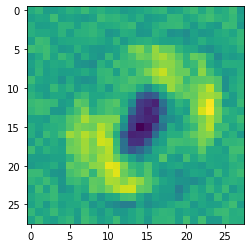

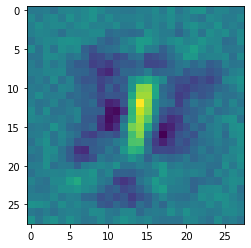

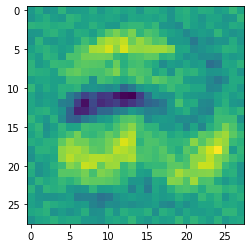

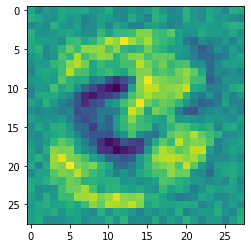

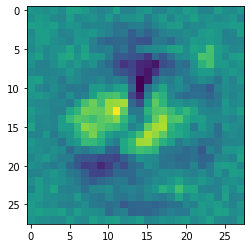

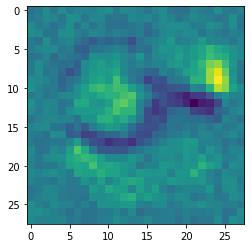

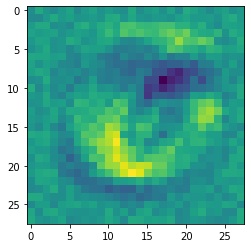

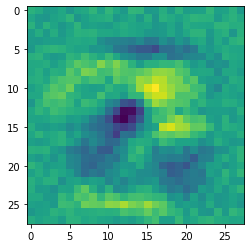

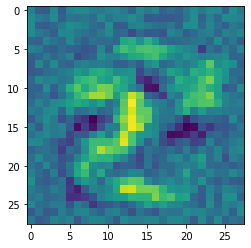

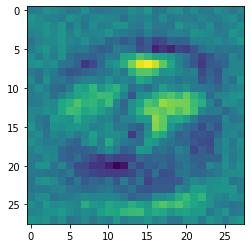

In [13]:
import math
#Accessing weight values and detaching from GPU to CPU
weight = list(model.children())[1].weight.cpu().data
#Getting Reshaping factor
size = weight.size()
root = int(math.sqrt(size[1]))
#Iterating over 10 digits visualize and save them
for idx in range(len(weight)):
    #Tensor to numpy then reshape to 28*28 mat
    weight_show = weight[idx].numpy().reshape(root,root)
    #Visualize
    plt.imshow(weight_show)
    plt.show()
    #Image save
    fname = "image_solutions/" + str(idx) +".jpg"
    plt.imsave(fname,weight_show)

### Task C
Now lets Change the Learning rate to lr = 1.0

In [14]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_org, test_loss_dict_org = trainer.train(num_epochs)
final_loss_org, final_acc_org = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

Training epoch 4: 100%|██████████| 938/938 [00:06<00:00, 152.93it/s]


In [15]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = 1.0
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_one, test_loss_dict_one = trainer.train(num_epochs)
final_loss_one, final_acc_one = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

Training epoch 4: 100%|██████████| 938/938 [00:06<00:00, 146.98it/s]


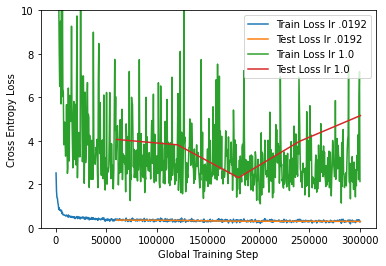

Final Test loss for lr 1.0: 0.2939866229203666. Final Test accuracy for lr 1.0: 0.9164
Final Test loss for lr 1.0: 5.1604970629048195. Final Test accuracy for lr 1.0: 0.7901


In [16]:
#Performence Visualization ORIGINAL vs lr = 1.0 optimizer:
# We can now plot the two models against each other
# Plot loss
utils.plot_loss(train_loss_dict_org, label="Train Loss lr .0192")
utils.plot_loss(test_loss_dict_org, label="Test Loss lr .0192")
utils.plot_loss(train_loss_dict_one, label="Train Loss lr 1.0")
utils.plot_loss(test_loss_dict_one, label="Test Loss lr 1.0")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 10])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4c.png")
plt.show()

torch.save(model.state_dict(), "saved_model.torch")
print(f"Final Test loss for lr 1.0: {final_loss_org}. Final Test accuracy for lr 0.0192: {final_acc_org}")
print(f"Final Test loss for lr 1.0: {final_loss_one}. Final Test accuracy for lr 1.0: {final_acc_one}")

### Task D
In This Part we will introduce another hidden layer to the model

In [17]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model creation
model = create_model()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_org, test_loss_dict_org = trainer.train(num_epochs)
final_loss_org, final_acc_org = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

Training epoch 4: 100%|██████████| 938/938 [00:06<00:00, 151.85it/s]


In [18]:
# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)

#Normalized dataset
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5),std = (0.5))
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

#Model Creation and Training
def create_model2():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1,64),#Hidden layer with 64 out features node
        nn.ReLU(), #Activation function
        nn.Linear(64, 10) #Output layer
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model

#Model creation
model = create_model2()

#Hyper parameter Selection
learning_rate = .0192
num_epochs = 5

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
#Trainer for Original Learning rate
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_new, test_loss_dict_new = trainer.train(num_epochs)
final_loss_new, final_acc_new = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

Training epoch 4: 100%|██████████| 938/938 [00:06<00:00, 150.60it/s]


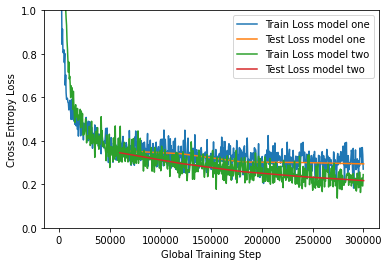

Final Test loss for model one: 0.2939866229203666. Final Test accuracy for model one: 0.9164
Final Test loss for model two: 0.2170549741275846. Final Test accuracy for model two: 0.9373


In [19]:
#Performence Visualization model one vs model two:
# We can now plot the two models against each other
# Plot loss
utils.plot_loss(train_loss_dict_org, label="Train Loss model one")
utils.plot_loss(test_loss_dict_org, label="Test Loss model one")
utils.plot_loss(train_loss_dict_new, label="Train Loss model two")
utils.plot_loss(test_loss_dict_new, label="Test Loss model two")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4d.png")
plt.show()

torch.save(model.state_dict(), "saved_model_new.torch")
print(f"Final Test loss for model one: {final_loss_org}. Final Test accuracy for model one: {final_acc_org}")
print(f"Final Test loss for model two: {final_loss_new}. Final Test accuracy for model two: {final_acc_new}")